# Predicting Brand Exposure

## 01_Analysis and Visualization
* Prepare and structure data for analysis.
* This step is intended for data exploration to see if we can find patterns and insights

## Import and Load Data

In [114]:
#import libraries
import pandas as pd
import json
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#load data
excel_file_path = '../data_archives/df.xlsx'
json_file_path = '../data_archives/local_venue_poptimes.json'
shapefile_path = '../resources/Hydrography_Polygon.shp'

df_raw = pd.read_excel(excel_file_path)   #dataframe of basic location information
json_data = open(json_file_path).read()   #json data that includes populartimes data
populartimes = json.loads(json_data)         #json data that includes populartimes data
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway

## Preprocess and Structure Data

In [179]:
#drop duplicate values
df_raw = df_raw.drop_duplicates(keep='first',subset=['google_id', 'name','WeekTotals']).reset_index()

In [116]:
#Define type map for dimensionality reduction of venue type
type_maps = {'finance':['accounting','finance','atm','bank'],
             'retail':['store','clothing_store','jewelry_store','electronics_store','shoe_store','book_store','home_goods_store','furniture_store','hardware_store','pet_store','department_store','shopping_mall'],
             'transportation':['airport','bus_station','transit_station','gas_station','parking','car_rental','train_station','subway_station','light_rail_station'],
             'food':['cafe','bakery','meal_takeaway','restaurant','food','convenience_store','meal_delivery'],
             'bar':['bar','night_club','liquor_store'],
             'grocery':['grocery_or_supermarket','supermarket'],
             'health_wellness':['health','beauty_salon','hair_care','spa','gym','dentist','doctor','hospital','pharmacy','physiotherapist'],
             'automotive':['car_repair'],
             'professional_services':['lawyer','insurance_agency','general_contractor','travel_agency','real_estate_agency','veterinary_care'],
             'culture_entertainment':['art_gallery','library','museum','movie_theater','park','natural_feature','bowling_alley'],
             'religous':['church','place_of_worship','mosque','synagogue'],
             'government':['courthouse','local_government_office','fire_station','police','post_office'],
             'education':['school','university'],
             'lodging':['lodging'],
             'other':['point_of_interest','establishment','moving_company','storage','premise','bicycle_store','florist','cemetery','laundry','painter','locksmith','plumber','roofing_contractor','car_dealer','car_wash','electrician']}

In [117]:
#Convert venue type, which is currently a string, 
#to a list of words for each record
from keras.preprocessing.text import text_to_word_sequence

df_processed = df_raw.copy(deep=True)

for i in range(len(df_raw)):
    a = text_to_word_sequence(df_raw.iloc[i]['venue_type'], 
                              filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', 
                              lower=False, 
                              split=' ')
    b = []
    for word in a:  
        c = text_to_word_sequence(word, 
                                  filters="'", 
                                  lower=False, 
                                  split=' ')
        b.append(c[0])
    df_processed.at[i,'venue_type'] = b
df_processed.head(1)

,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals
0,0,Ellis PC,42.348034,-71.041187,ChIJq6qaXoJ644kRoNxCzt2rYyw,"[accounting, finance, point_of_interest, estab...",0,0,0,0,0,0,0,0


In [118]:
#map venue_type to one value based on type_map dictionary
type_list = []
for i in range(len(df_processed)):
    vals_to_map = df_processed.iloc[i]['venue_type']    
    for item in vals_to_map:
        for key in list(type_maps.keys()):            
            list_to_check = type_maps[key]            
            if item in list_to_check:
                type_list.append(key)
                break
        if item in list_to_check:
            break
df_processed['mapped_venue_type'] = pd.DataFrame({'type':type_list})
print(len(type_list))
df_processed.head()

1908


,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type
0,0,Ellis PC,42.348034,-71.041187,ChIJq6qaXoJ644kRoNxCzt2rYyw,"[accounting, finance, point_of_interest, estab...",0,0,0,0,0,0,0,0,finance
1,1,"WithumSmith+Brown, PC",42.349607,-71.042722,ChIJydm7oHhw44kRYeJauZOvntA,"[accounting, finance, point_of_interest, estab...",0,0,0,0,0,0,0,0,finance
2,2,Cantor Stefanie D,42.349819,-71.042828,ChIJ0VvNp3hw44kRxv4C86Zgsi8,"[lawyer, accounting, finance, point_of_interes...",0,0,0,0,0,0,0,0,professional_services
3,3,Goodwin Procter Boston,42.352191,-71.043785,ChIJzyWROoRw44kR__T4RIymGyw,"[accounting, lawyer, finance, point_of_interes...",690,947,788,1020,630,0,0,4075,finance
4,4,PwC,42.351162,-71.045188,ChIJ30VlLIJw44kRk4x9eEYUtbg,"[accounting, finance, point_of_interest, estab...",525,558,575,644,755,0,0,3057,finance


In [119]:
#build dataframe that expands records for every hour of activity during the day
#initialize empty lists
records_lat = []
records_lng = []
records_count = []
records_hour = []
records_day = []
records_google_id = []
records_name = []
#loop through each hour of each day for every venue and store lat, long, count, and hour into a dataframe
for day in range(6):
    for hour in range(24):
        for venue in range(len(populartimes)):
            venue_lat = populartimes[venue]['coordinates']['lat']
            venue_lng = populartimes[venue]['coordinates']['lng']
            count = populartimes[venue]['populartimes'][day]['data'][hour]
            hour_of_day = hour
            day_of_week = day
            google_id = populartimes[venue]['id']
            name = populartimes[venue]['name']
            
            #append data to list
            records_lat.append(venue_lat)
            records_lng.append(venue_lng)
            records_count.append(count)
            records_hour.append(hour_of_day)
            records_day.append(day_of_week)
            records_google_id.append(google_id)
            records_name.append(name)

#save lists to dataframe            
df_time_records = pd.DataFrame({"lat":records_lat,
                                "lng":records_lng,
                                "count":records_count,
                                "hour":records_hour,
                                "day":records_day,
                                "google_id":records_google_id,
                                "name":records_name})
df_time_records.head()

,lat,lng,count,hour,day,google_id,name
0,42.352191,-71.043785,0,0,0,ChIJzyWROoRw44kR__T4RIymGyw,Goodwin Procter Boston
1,42.351162,-71.045188,0,0,0,ChIJ30VlLIJw44kRk4x9eEYUtbg,PwC
2,42.374258,-71.024628,56,0,0,ChIJmd9BFjhw44kRHqSMe4nZ2a4,JetBlue Airways (Maintenance-Materials) Hangar...
3,42.374899,-71.023227,8,0,0,ChIJnfWx5Ddw44kRKctc5RWyWLg,Signature Flight Support BOS - Boston Logan In...
4,42.344821,-71.035269,0,0,0,ChIJnV-rvpx644kRceTt-zDSXhE,Dunkin' Donuts


In [120]:
df_time_records = df_time_records.join(df_processed[['google_id','mapped_venue_type']].set_index('google_id'), on='google_id')
df_time_records = test.drop_duplicates(keep='first',subset=['hour', 'day','google_id']).reset_index()
df_time_records.head(2)

,level_0,index,lat,lng,count,hour,day,google_id,name,mapped_venue_type
0,0,0,42.352191,-71.043785,0,0,0,ChIJzyWROoRw44kR__T4RIymGyw,Goodwin Procter Boston,finance
1,1,1,42.351162,-71.045188,0,0,0,ChIJ30VlLIJw44kRk4x9eEYUtbg,PwC,finance


In [121]:
#prepare data for kde by building a list of records 
#for each user count at each location
kde_x = []
kde_y = []

for i in range(len(df_raw)):
    lat = df_raw.iloc[i]['lat']
    lng = df_raw.iloc[i]['long']
    count = df_raw.iloc[i]['WeekTotals']
    if count > 0:
        for j in range(count):
            kde_x.append(lat)
            kde_y.append(lng)

## Visualize Data

In [122]:
#Prepare Plot Parameters
#define plot ranges
x_min = -71.078
y_min = 42.32
x_max = -71.008
y_max = 42.37

#figure size
plot_size = (15,11)

### plot kde

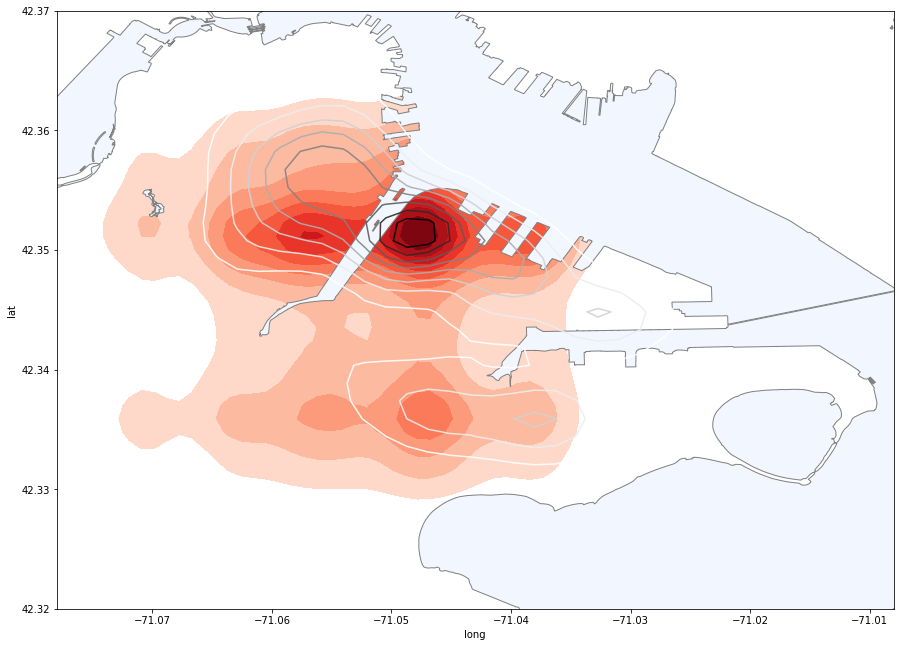

In [178]:
#define sample size
sample_size=10000

#sample data
X_sample = np.random.choice(kde_x,size=sample_size,replace=False)
y_sample = np.random.choice(kde_y,size=sample_size,replace=False)

#define plot size
f, ax = plt.subplots(1, figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot kde of user density
ax = sns.kdeplot(y_sample, X_sample, shade=True,cmap="Reds",shade_lowest=False)
#plot kde of  store density
ax = sns.kdeplot(df_processed['long'], df_processed['lat'],shade=False,alpha=0.9,shade_lowest=False,cmap="Greys")
#plot shapefile of boston waterway
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')

#save to file
plt.savefig("../data_archives/plot_exports/kde/sample_{}.jpg".format(sample_size), dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
#show plot
plt.show()

## box and whisker for each venue type

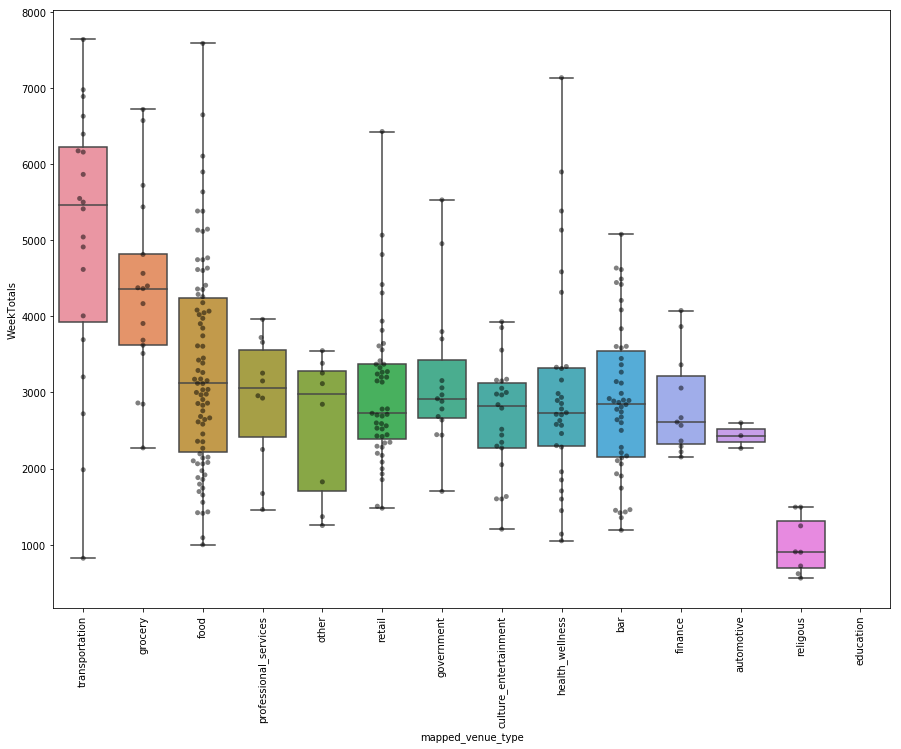

In [124]:
#sample data where we have count data
box_sample_data = df_processed[df_processed['WeekTotals']>0] #.sample(2000)

#define order of x axis
x_order = ["transportation", "grocery", "food",
         "professional_services","other","retail","government","culture_entertainment",
         "health_wellness","bar","finance",
         "automotive","religous","education"]

#define plot size
f, ax = plt.subplots(1, figsize=plot_size)

#plot boxplot
ax = sns.boxplot(x="mapped_venue_type", y="WeekTotals", data=box_sample_data, whis=np.inf, order=x_order)
#plot swarmplot
ax = sns.swarmplot(x="mapped_venue_type", y="WeekTotals", data=box_sample_data, color='black',alpha=0.5,order=x_order)

#rotate x axis labels 
plt.xticks(rotation=90)

#save image to file
plt.savefig("../data_archives/plot_exports/box_swarm/box_swarm1.jpg", dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)

### plot map of store location

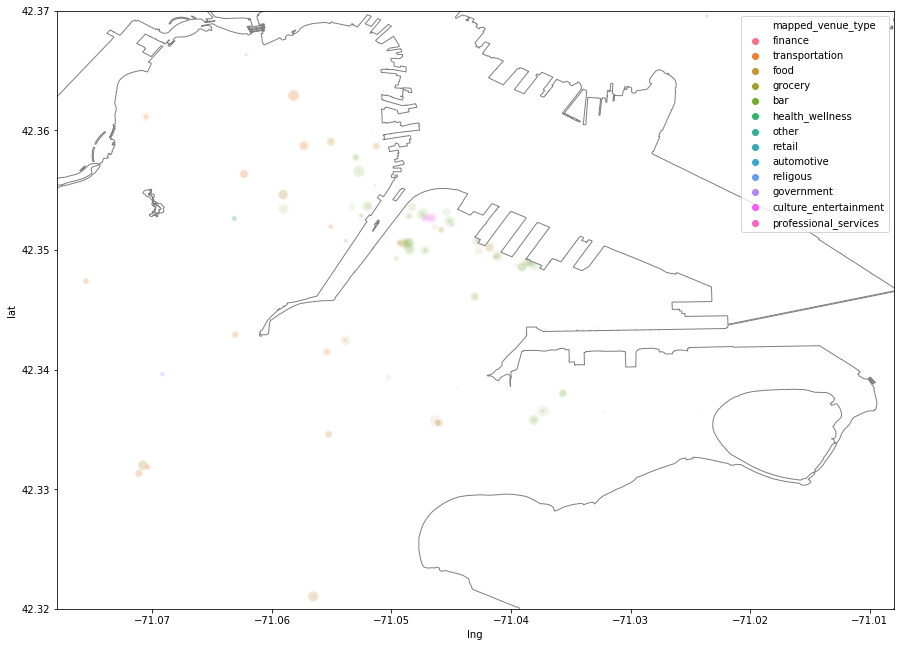

In [177]:
#define plot size
plt.figure(figsize=plot_size)

#plot figure for each hour of the day
for i in range(24):    
    #plot scatter of store locations
    ax = sns.scatterplot(x='lng', y='lat', 
                         data=df_time_records[df_time_records["hour"]==i],
                         s=1.5*df_time_records[df_time_records["hour"]==i]["count"],
                         alpha=0.05,
                         hue='mapped_venue_type')
    
    #overlay shapefile of botston waterway
    ax = shapefile.plot(ax=ax,alpha=1.0,edgecolor='grey',facecolor='white')
    
    #define plot ranges
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    #save figure to file
    '''plt.savefig("../data_archives/plot_exports/scatter_map_color/exp_hour_{}.jpg".format(i), dpi=300, facecolor='w', edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)'''
    plt.clf
    plt.close
    if i < 23:
        plt.cla()

### activity heatmap - combined

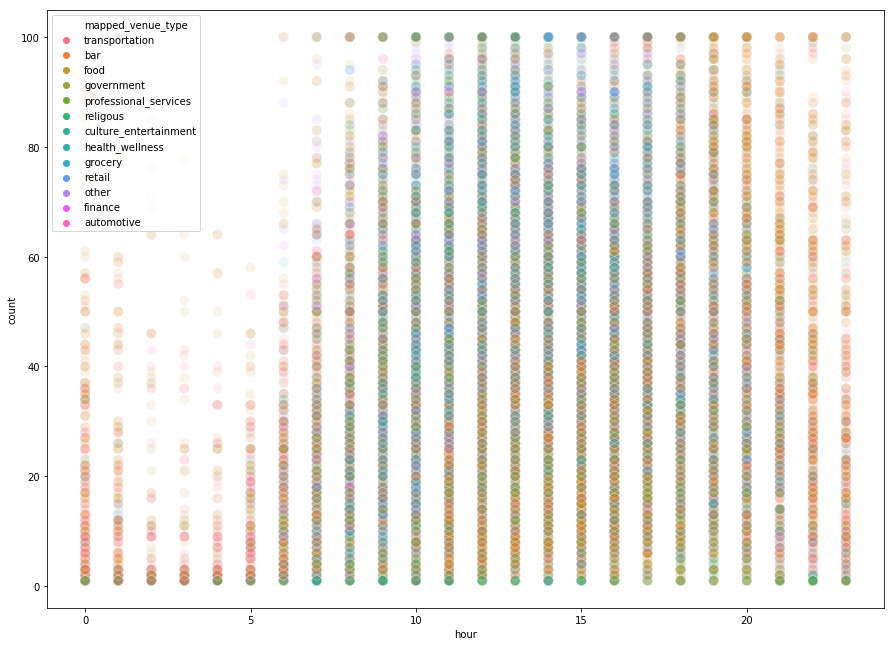

In [132]:
#define plot size
plt.figure(figsize=plot_size)

#plot figure
ax = sns.scatterplot(x='hour', y='count', 
                         data=df_time_records[df_time_records['count']>0],s=100,
                         alpha=0.1,
                         hue='mapped_venue_type')
plt.show()

### activity heatmap - by program

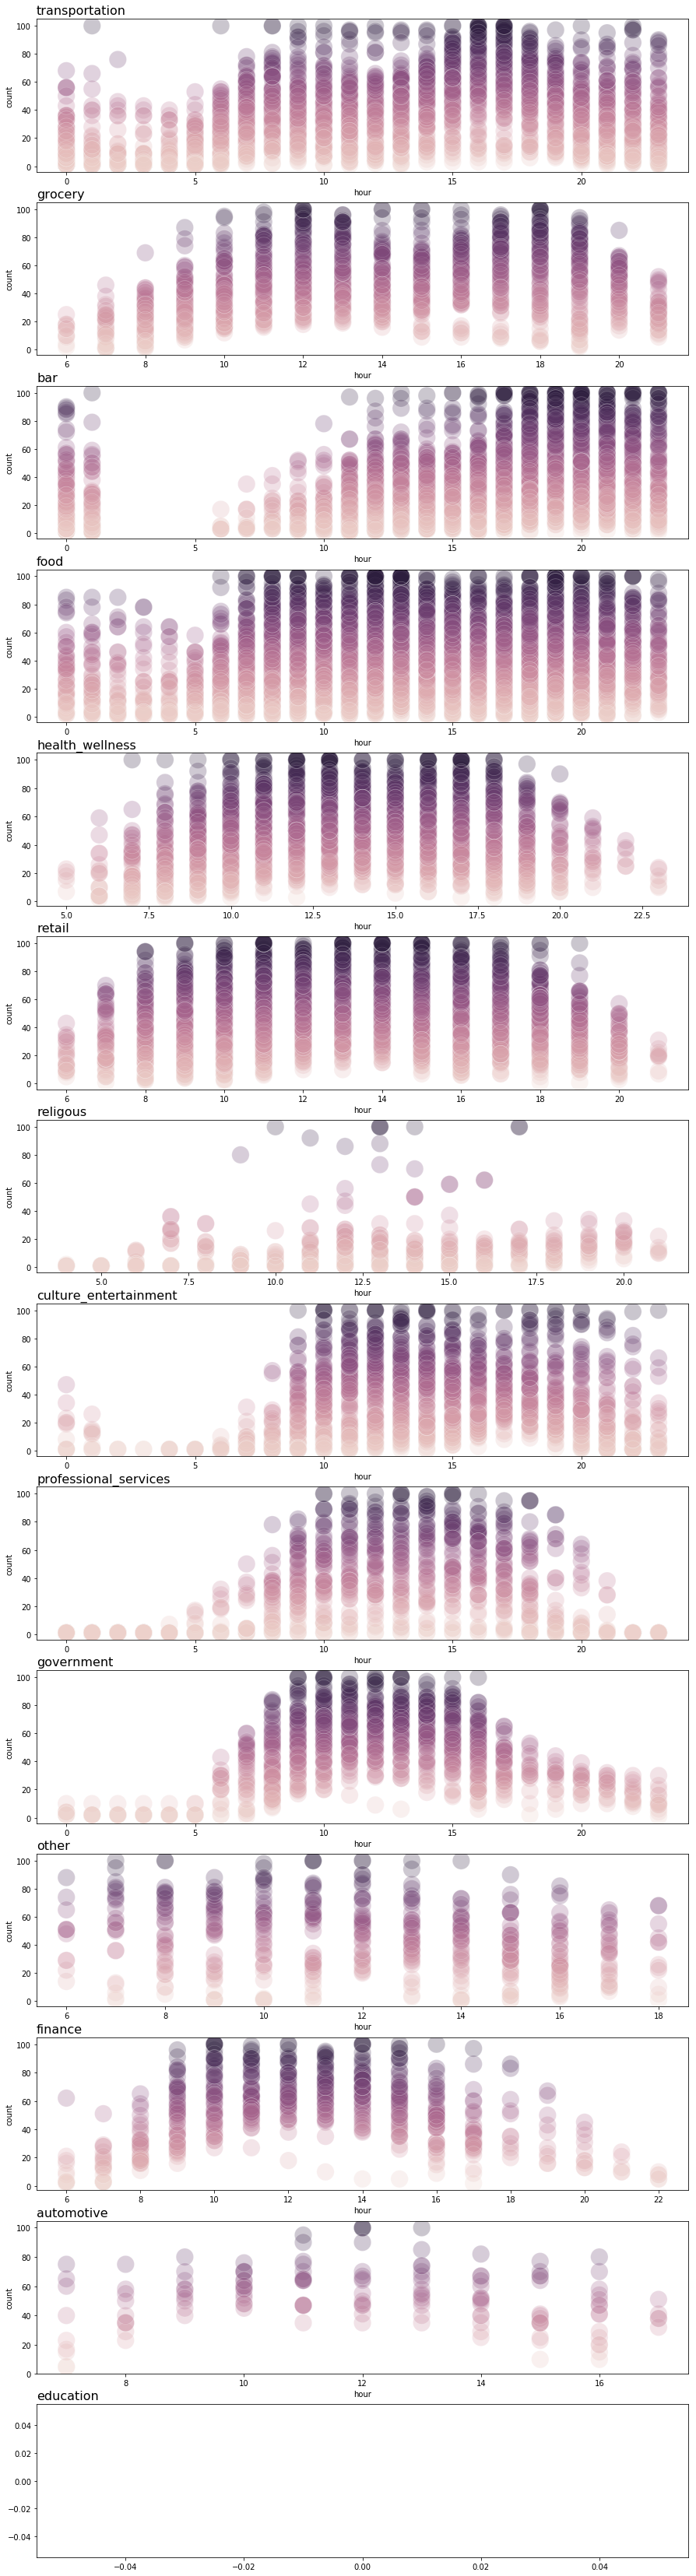

In [175]:
#define plot size
plt.figure(figsize=(15,60))

time_data = df_time_records[df_time_records['count']>0]

plot_cols = 1
plot_rows = len(set(df_processed['mapped_venue_type']))
counter = 1
for v_type in set(set(df_processed['mapped_venue_type'])):

    plt.subplot(plot_rows,plot_cols,counter)
    ax = sns.scatterplot(x='hour', y='count', 
                         data=time_data[time_data['mapped_venue_type']==v_type],
                         s=500,
                         alpha=.25,
                         hue='count',
                         marker='o')
    
    plt.title(v_type,fontsize=16, loc='left')
    
    try:
        ax.legend_.remove()
    except:
        pass
    counter += 1
plt.savefig("../data_archives/plot_exports/heat_plot/program_heat_plot.jpg".format(i), dpi=300, facecolor='w', edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None)
plt.show()